## Setup - Do once (Only in Colab)

In [1]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




In [2]:
if (IN_COLAB):
    %%capture
    !pip install PyPortfolioOpt==0.5.3
    !pip install pandas==0.22.0
    !pip install zipline==1.3.0
    !pip install pyfolio
    !pip install cvxopt
    !pip install yahoofinancials

In [3]:
if (IN_COLAB):
    # Some files need to be modified
    !ls /root
    #!cp setup/extension.py ~/.zipline/extension.py
    !cp setup/benchmarks.py /usr/local/lib/python3.6/dist-packages/zipline/data/benchmarks.py
    !cp setup/loader.py /usr/local/lib/python3.6/dist-packages/zipline/data/loader.py


## Input and Function definitions

In [1]:
#@title Input Variables
_visualise = True #@param ["True", "False"] {type:"raw"}
_bundle_start_date = '2015-01-05' #'2015-01-05' #@param {type:"date"}
_bundle_end_date = '2020-04-03' #@param {type:"date"}
# _end_date = '2019-12-27' #@param {type:"date"}
_capital = 1000000 #@param {type:"slider", min:1000, max:1000000, step:1000}
_benchmark = 'SPY' #@param ["SPY"] {allow-input: true}
_history = 500 #@param {type:"slider", min:100, max:500, step:1}
_calendar = 'NYSE' #@param ["NYSE"] {allow-input: true}

# set algo start date equal to bundle start date
# _start_date = _bundle_start_date
# _end_date = _bundle_end_date

_start_date = '2018-07-21'
_end_date = '2020-04-03'

args = {
    'mode': '1',
    'visualise': _visualise, 
    'start_date': _start_date,
    'end_date': _end_date,
    'bundle_start_date': _bundle_start_date,
    'bundle_end_date': _bundle_end_date,
    'bundle': 'robo-advisor_US',
    'timezone': 'US/Mountain',
    'calendar': _calendar,
    'capital': _capital,
    'benchmark': _benchmark,
    'history': _history
}


### Register and ingest bundle

In [2]:
import sys
sys.path.append('..')  # add parent folder to sys path

import pandas as pd
from zipline.data.bundles import register, ingest, unregister, bundles
from zipline.data.bundles.csvdir import csvdir_equities

import os
from zipline.utils.run_algo import load_extensions

start_session = pd.Timestamp(args['bundle_start_date'], tz='utc')
end_session = pd.Timestamp(args['bundle_end_date'], tz='utc')
bundle_name = args['bundle']

load_extensions(default=True, extensions=[], strict=True, environ=os.environ)

# unregister bundle if already exists
if bundle_name in list(bundles):
    unregister(bundle_name)

# register and ingest the bundle
register(
    bundle_name,  # name we select for the bundle
    csvdir_equities(        
        ['daily'], # name of the directory as specified above (named after data frequency)        
        '../data', # path to directory containing the data
    ),
    calendar_name=args['calendar'],  # US Equities
    start_session=start_session,
    end_session=end_session
)


ingest(bundle_name)



 | BND: sid 0
 | BNDX: sid 1
 | DBC: sid 2
 | GLD: sid 3
 | IEF: sid 4
 | SPY: sid 5
 | TLT: sid 6
 | VTI: sid 7
 | VXUS: sid 8
 | XLB: sid 9
 | XLC: sid 10
 | XLE: sid 11
 | XLF: sid 12
 | XLI: sid 13
 | XLK: sid 14
 | XLP: sid 15
 | XLRE: sid 16
 | XLU: sid 17
 | XLV: sid 18
 | XLY: sid 19


Bundle details: RegisteredBundle(calendar_name='NYSE', start_session=Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), end_session=Timestamp('2020-04-03 00:00:00+0000', tz='UTC'), minutes_per_day=390, ingest=<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x000001E598F6DC18>>, create_writers=True)

Asset list: [Equity(0 [BND]), Equity(1 [BNDX]), Equity(2 [DBC]), Equity(3 [GLD]), Equity(4 [IEF]), Equity(5 [SPY]), Equity(6 [TLT]), Equity(7 [VTI]), Equity(8 [VXUS]), Equity(9 [XLB]), Equity(10 [XLC]), Equity(11 [XLE]), Equity(12 [XLF]), Equity(13 [XLI]), Equity(14 [XLK]), Equity(15 [XLP]), Equity(16 [XLRE]), Equity(17 [XLU]), Equity(18 [XLV]), Equity(19 [XLY])]



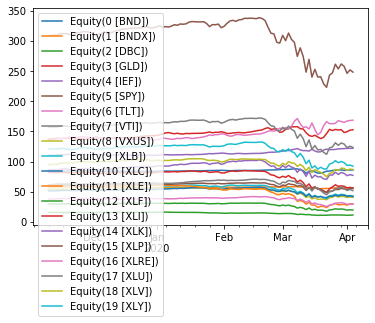

In [3]:
# Verify that bundle has been registered 
from zipline.data import bundles
bundle = bundles.load(bundle_name)
assets = bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
symbols = [a.symbol for a in assets]

print('Bundle details:', bundles.bundles[bundle_name])
print('\nAsset list:', bundle.asset_finder.retrieve_all(bundle.asset_finder.sids))
print()

# See sample of data
from zipline.data.data_portal import DataPortal
from zipline.utils.calendars import get_calendar
my_data = DataPortal(bundle.asset_finder, get_calendar(args['calendar']),
                       bundle.equity_daily_bar_reader.first_trading_day,
                       equity_minute_reader=bundle.equity_minute_bar_reader,
                       equity_daily_reader=bundle.equity_daily_bar_reader,
                       adjustment_reader=bundle.adjustment_reader)

my_data_pricing = my_data.get_history_window(assets, end_session, 100, '1d', 'close', 'daily')
my_data_pricing.plot()


## Run Algorithms

In [4]:
# initialise variables
import matplotlib.pyplot as plt
from zipline.api import *
from zipline.api import symbols
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm
from datetime import datetime, timedelta
import pytz

tz = pytz.timezone(args['timezone'])
bundle_name = args['bundle'] # bundle = 'alpaca'

raw_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))

# calculate actual start date, 
# taking into account required HISTORY of trading days for given trading calendar
tc = get_calendar(args['calendar'])
# start = tc.sessions_window(start_session, args['history'])[-1] # start = raw_start + trading_days(HISTORY)
start = raw_start

end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))
capital_base = args['capital'] # 100000.00 

print(f'Algorithm will start with capital of ${capital_base:,d}.')
print('Backtest from %s to %s' % (start, end))
print('History will be collected for %d trading-days from %s' % (args['history'], raw_start))

Algorithm will start with capital of $1,000,000.
Backtest from 2018-07-21 00:00:00-06:00 to 2020-04-03 00:00:00-06:00
History will be collected for 500 trading-days from 2018-07-21 00:00:00-06:00


### Portfolios based on asset classes

### Algorithm 1 - pre-assembled fixed basket of ETFs with constant-mix rebalancing 

1A - Vanguard Core Series with risk-baskets

In [10]:
import sys
sys.path.append('..')  # add parent folder to sys path
from tqdm import tqdm
from algorithms import CRBAlgorithm, run
a_vanguard = CRBAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES")

enabled = False

if (enabled):
    # run algorithm for a range of risk levels
    perfData = []
    step = 5
    for r in tqdm(range(0, 10, step)):
        a_vanguard.risk_level = r
        perfData.append(run("RISK%i" % r, a_vanguard, bundle_name, start, end, capital_base, analyze=False))
                
#         perfData.append(("RISK%i" % r, run_algorithm(start=start, end=end,
#                         initialize=a_vanguard.initialize, handle_data=a_vanguard.handle_data,                            
#                         capital_base=capital_base, environ=os.environ, bundle=bundle_name
#                         # analyze=analyze,
#         )))

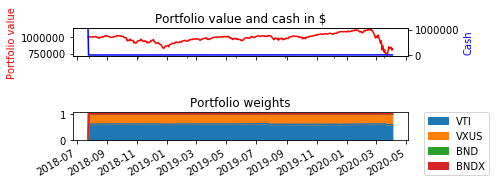

d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,


In [9]:
# Compare daily vs monthly rebalancing
a_vanguard.risk_level = 10
a_vanguard.rebalance_freq = 'daily'
test = []
test.append(run("rebal daily", a_vanguard, bundle_name, start, end, capital_base, analyze=True))

a_vanguard.rebalance_freq = 'monthly'
test.append(run("rebal monthly", a_vanguard, bundle_name, start, end, capital_base, analyze=False))

from utils import print_table_from_perf_array
print_table_from_perf_array(test, None)

1B - Ray Dalio's simplified "All Weather" Portfolio that is designed to weather through any financial climate.
It advocates the following distribution:
* 30% stocks (eg VTI)
* 40% long-term bonds (eg TLT)
* 15% intermediate-term bonds (eg IEF)
* 7.5% gold (eg GLD)
* 7.5% commodities (eg DBC)

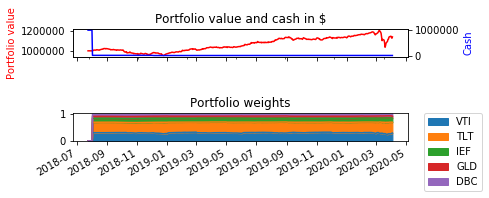

In [7]:
from algorithms import CRBAlgorithm
a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")

if ('perfData' not in locals()): perfData = []
perfData.append(run("All Weather", a_dalio, bundle_name, start, end, capital_base))

### Algorithm 2 - pre-assembled fixed basket of ETFs with Modern Portfolio Theory for rebalancing

MPT (max sharpe)


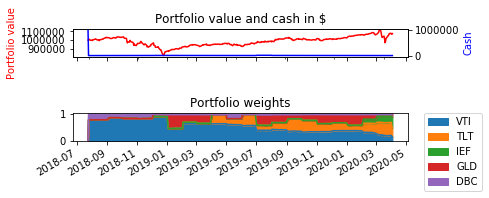

MPT (min volatility)


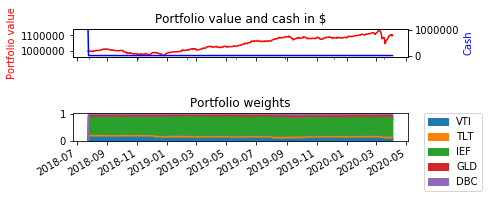

In [8]:
from algorithms import OptAlgorithm

COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# # MPT for max-sharpe
# a_mpt1 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='max_sharpe')

# # MPT for min-volatility
# a_mpt2 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='min_volatility')

a_mpt1 = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='max_sharpe')

# MPT for min-volatility
a_mpt2 = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='min_volatility')


print('MPT (max sharpe)')
perfData.append(run("MPT (max sharpe)", a_mpt1, bundle_name, start, end, capital_base))

print('MPT (min volatility)')
perfData.append(run("MPT (min volatility)", a_mpt2, bundle_name, start, end, capital_base))

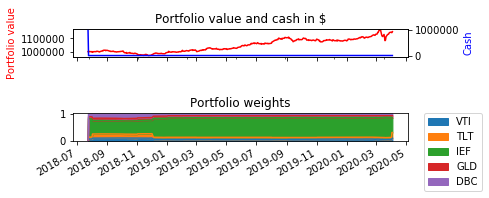

In [9]:
from algorithms import OptAlgorithm

COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# Hierarchical risk parity portfolio
# a_hrp = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
#                       collect_before_trading=COLLECT_BEFORE_TRADING,
#                       history=args['history'], objective='hrp')
a_hrp = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='hrp')

perfData.append(run("HRP", a_hrp, bundle_name, start, end, capital_base))

### Results Comparison

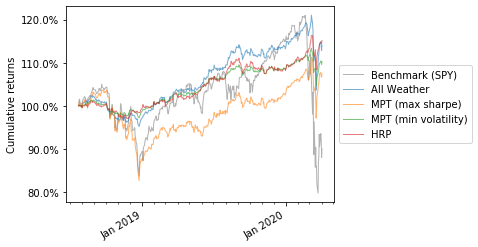

In [10]:
# Get benchmark returns and compare it with our algorithm's returns
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']
plot_rolling_returns_from_perf_array(perfData, bm_returns)

In [11]:
from utils import print_table_from_perf_array
print_table_from_perf_array(perfData, bm_returns, True)

### Portfolios based on sectors
with universe of 11 SPDR sector ETFs

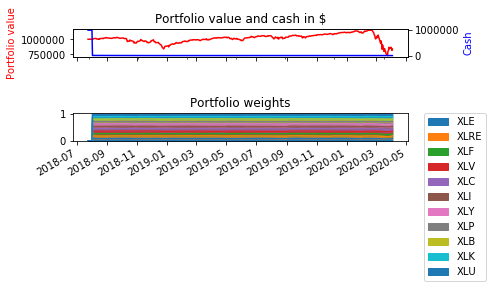

In [12]:
from algorithms import CRBAlgorithm
a_spy1 = CRBAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS")

if ('perfSPDR' not in locals()): perfSPDR = []
perfSPDR.append(run("Constant-Rebalancing (Equal weights)", a_spy1, bundle_name, start, end, capital_base))

MPT (max sharpe)


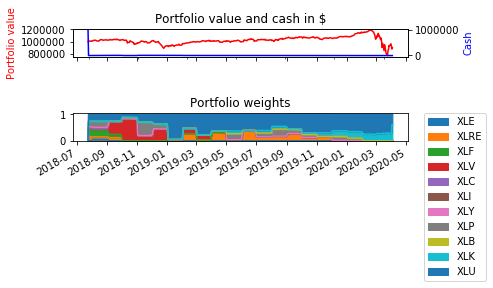

MPT (min volatility)


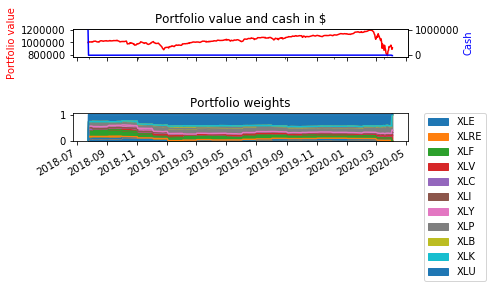

HRP


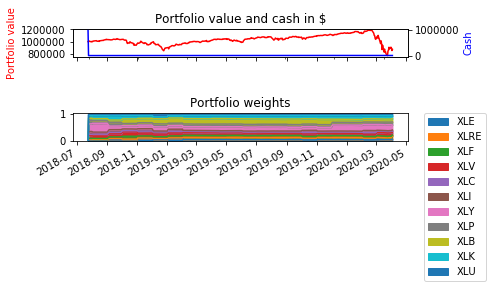

In [13]:
from algorithms import OptAlgorithm
a_spy2_ms = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='max_sharpe')
a_spy2_mv = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='min_volatility')
a_sp2_hrp = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='hrp')

if ('perfSPDR' not in locals()): perfSPDR = []
print("MPT (max sharpe)")
perfSPDR.append(run("MPT (max sharpe)", a_spy2_ms, bundle_name, start, end, capital_base))

print("MPT (min volatility)")
perfSPDR.append(run("MPT (min volatility)", a_spy2_mv, bundle_name, start, end, capital_base))

print("HRP")
perfSPDR.append(run("HRP", a_sp2_hrp, bundle_name, start, end, capital_base))

In [5]:
# Get benchmark returns and compare it with our algorithm's returns
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array
from utils import print_table_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']

plot_rolling_returns_from_perf_array(perfSPDR, bm_returns)
print_table_from_perf_array(perfSPDR, bm_returns, True)

NameError: name 'perfSPDR' is not defined

### Conclusion: It seems that sector-based portfolio does not benefit much from portfolio optimisation

---

### Use Sentiments as trading signals to optimise portfolio based on asset-classes

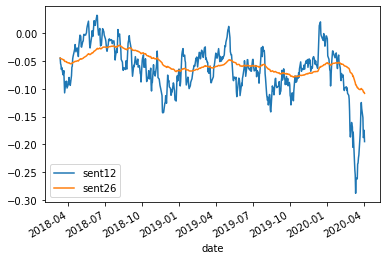

In [11]:
trade_freq = 'weekly'
history = 7

filepath='../data/twitter/sentiments_overall_daily.csv'
social_media = pd.read_csv(filepath, usecols=['date', 'buzz', 'finBERT', 'sent12', 'sent26'])
social_media['date'] = pd.to_datetime(social_media['date'], format="%Y-%m-%d", utc=True)
social_media.set_index('date', inplace=True, drop=True)

social_media[['sent12', 'sent26']].plot()

Buy the index SPY, but use trading signals from the prediction model

Baseline: Buy-and-hold SPY

In [12]:
# Get benchmark returns for comparison
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array
from utils import print_table_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']


d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,


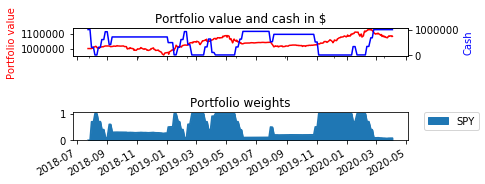

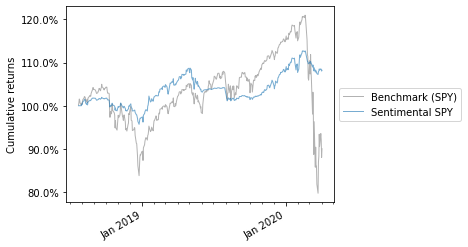

In [13]:
from algorithms import TradingSignalAlgorithm

def trading_fn(stockname, date, lookback):    
    df = social_media
    yesterday_date = date - pd.Timedelta(days=1)
    yesterday_social_media = df.iloc[df.index.get_loc(yesterday_date, method='nearest')]
    
    # if sent12 > sent26 -> buy
    # if sent12 < sent26 -> sell    
    buzz = yesterday_social_media['buzz']
    sentiment = yesterday_social_media['sent12'] - yesterday_social_media['sent26']
    
    signal = 0
    if sentiment > 0: signal = 0.5
    elif sentiment < 0: signal = -0.3
    return signal
    
a_index = TradingSignalAlgorithm(verbose=False, stocks=['SPY'], rebalance_freq=trade_freq, trading_signal=trading_fn)

perfTS = []
if ('perfTS' not in locals()): perfTS = []
a_index_results = run("Sentimental SPY", a_index, bundle_name, start, end, capital_base)
perfTS.append(a_index_results)

plot_rolling_returns_from_perf_array([a_index_results], bm_returns)
print_table_from_perf_array(perfTS, bm_returns, True)


It seems like it is able to minimise losses during rapid selling, but we end up holding a lot of uninvested cash during market crashes

---

Use All-Weather portfolio, but use trading signals to adjust allocation (eg shift to bonds/gold when market is bad)

Let's call this "Sentimental All-Weather" (SAW)

Baseline: All-Weather

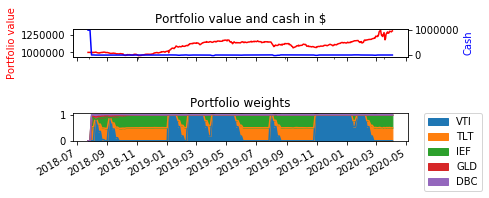

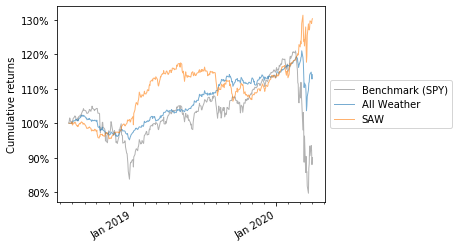

In [14]:
from algorithms import CRBAlgorithm
from algorithms import TradingSignalAlgorithm
a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")
bm_all_weather = run("All Weather", a_dalio, bundle_name, start, end, capital_base, analyze=False)

# 'VTI' - stock, 'TLT' - long-term bond, 'IEF'- medium-term bond, 'GLD'- commodity, 'DBC'- commodities
def saw_trading_fn(stock, date, lookback):
    stockname = stock.symbol
    df = social_media
    yesterday_date = date - pd.Timedelta(days=1)
    yesterday_social_media = df.iloc[df.index.get_loc(yesterday_date, method='nearest')]
    
    # if sent12 > sent26 -> bullish --> buy stocks, sell bonds
    # if sent12 < sent26 -> sell --> sell stocks, buy bonds
    buzz = yesterday_social_media['buzz']
    sentiment = yesterday_social_media['sent12'] - yesterday_social_media['sent26']
    
    # just try some parameters
    signal = 0
    if stockname not in ['GLD', 'DBC']:
        if sentiment > 0: signal = 0.5 if stockname in ['VTI'] else -0.5
        elif sentiment < 0: signal = -0.3 if stockname in ['VTI'] else 0.3
                
    return signal
    


a_saw = TradingSignalAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                                       rebalance_freq=trade_freq, trading_signal=saw_trading_fn, 
                                      initial_weights=[0.3,0.4,0.15,0.075,0.075], normalise_weights=True)

# if ('perfTS' not in locals()): perfTS = []
a_saw_results = run("SAW", a_saw, bundle_name, start, end, capital_base)
# perfTS.append(a_all_weather_results)

plot_rolling_returns_from_perf_array([bm_all_weather, a_saw_results], bm_returns)
print_table_from_perf_array([bm_all_weather, a_saw_results], bm_returns, True)

Since this looks promising (Annual returns of 16.9%, and max draw-down of only 10% despite the covid-19 market crash), let's see if we can optimise the parameters

Let's use Genetic Algorithm (GA) to optimise parameters

In [1]:
import sys
sys.path.append('..')  # add parent folder to sys path
# import ga
# ga.example(npop=5, ngen=2, filepath="../data/twitter/sentiments_overall_daily.csv")

from utils import isnotebook
print(isnotebook())

True


In [25]:
import ga
import pickle
from collections import OrderedDict
from tqdm.notebook import tqdm   # override tqdm import with notebook version

# Let's train based on data prior to 2020-01-01, and test on data after that.
# This will test whether the optimised parameters are robust and able to perform in the covid-19 market crash
train_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))
train_end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))
test_start = tz.localize(datetime.strptime('2020-01-02', '%Y-%m-%d'))
test_end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather

NPOP = 50
NGEN = 4
seed = 85
toSolve1 = True
toSolve2 = False

pickle_max_ret = "SAW_GA_MAX_RET"
pickle_min_vol = "SAW_GA_MIN_VOL"


kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, "capital_base": capital_base, 
          "trade_freq": trade_freq}

if toSolve1:
    # Solve for max returns
    top10_max_ret, log, hof_max_ret = ga.run_saw_ga("FitnessMax", NPOP, NGEN, pickle_max_ret,
                       eval_fn=ga.eval_cumu_returns, stocks=stocks, seed=seed, **kwargs)
else:
    with open(f"{pickle_max_ret}.pickle", "rb+") as f:
        top10_max_ret = pickle.load(f)    

if toSolve2:
    # Solve for min volatility
    top10_min_vol, log, hof_min_vol = ga.run_saw_ga("FitnessMin", NPOP, NGEN, pickle_min_vol, 
                       eval_fn=ga.eval_min_vol, stocks=stocks, seed=seed, **kwargs)        
else:
    with open(f"{pickle_min_vol}.pickle", "rb+") as f:
        top10_min_vol = pickle.load(f)

        
best_max_ret = top10_max_ret[0]
best_min_vol = top10_min_vol[0]
w_max_ret = OrderedDict()
w_min_vol = OrderedDict()
i = 0

for s in stocks:
    w_max_ret[s] = {"p": best_max_ret[i], "n": best_max_ret[i+1]}
    w_min_vol[s] = {"p": best_min_vol[i], "n": best_min_vol[i+1]}
    i = i + 2

Genetic Algorithm. Fitness: FitnessMax, for 4 generations of 50 population each. Seed=85


d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


GA-optmised SAW for max returns


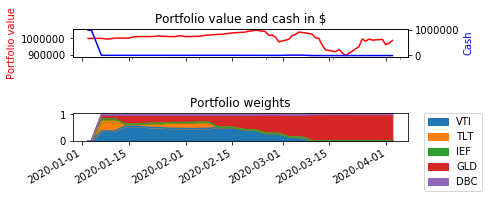

GA-optmised SAW for min volatility


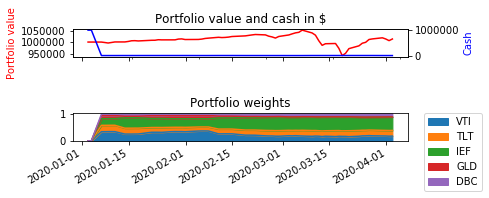

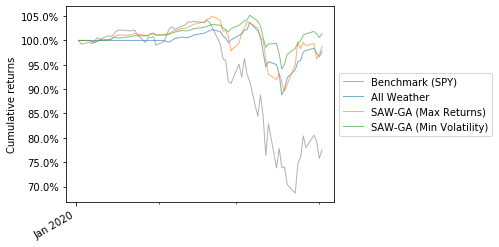

In [26]:
# Test on out-of-sample data
algo_max_ret = TradingSignalAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                                   rebalance_freq=trade_freq, trading_signal=ga.saw_ga_trading_fn, 
                                  initial_weights=[0.3,0.4,0.15,0.075,0.075], normalise_weights=True, 
                                      **{"weights": w_max_ret, "social_media": social_media})

print("GA-optmised SAW for max returns")
saw_ga_max_ret_test = run("SAW-GA (Max Returns)", algo_max_ret, bundle_name, test_start, test_end, capital_base, analyze=True)


algo_min_vol = TradingSignalAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                                   rebalance_freq=trade_freq, trading_signal=ga.saw_ga_trading_fn, 
                                  initial_weights=[0.3,0.4,0.15,0.075,0.075], normalise_weights=True, 
                                      **{"weights": w_min_vol, "social_media": social_media})

print("GA-optmised SAW for min volatility")
saw_ga_min_vol_test = run("SAW-GA (Min Volatility)", algo_min_vol, bundle_name, test_start, test_end, capital_base, analyze=True)

print()
bm_test = get_benchmark_returns(args['benchmark'], test_start, test_end)  # requires network connection
bm_test.name = 'Benchmark (%s)' % args['benchmark']

a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")
bm_aw_test = run("All Weather", a_dalio, bundle_name, test_start, test_end, capital_base, analyze=False)


plot_rolling_returns_from_perf_array([bm_aw_test, saw_ga_max_ret_test, saw_ga_min_vol_test], bm_test)
print_table_from_perf_array([bm_aw_test, saw_ga_max_ret_test, saw_ga_min_vol_test], bm_test, True)

GA-optmised SAW for max returns


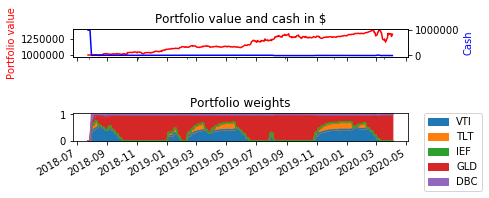

GA-optmised SAW for min volatility


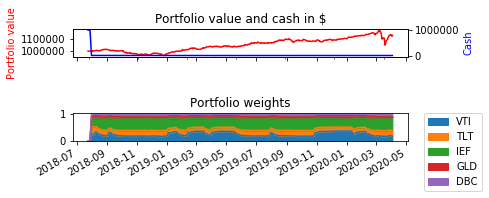

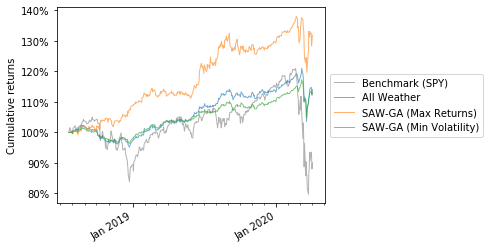

In [27]:
# Test on entire period
print("GA-optmised SAW for max returns")
saw_ga_max_ret_results = run("SAW-GA (Max Returns)", algo_max_ret, bundle_name, train_start, test_end, capital_base, analyze=True)

print("GA-optmised SAW for min volatility")
saw_ga_min_vol_results = run("SAW-GA (Min Volatility)", algo_min_vol, bundle_name, train_start, test_end, capital_base, analyze=True)

plot_rolling_returns_from_perf_array([bm_all_weather, saw_ga_max_ret_results, saw_ga_min_vol_results], bm_returns)
print_table_from_perf_array([bm_all_weather, saw_ga_max_ret_results, saw_ga_min_vol_results], bm_returns, True)

---

We can repeat the above for various population size, generations, and random seed... 

After running for multiple times, let's compare all the results

In [28]:
from ga import compareResults

kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, 
          "test_start": test_start, "test_end": test_end, 
          "capital_base": capital_base, 
          "stocks": stocks, "trade_freq": trade_freq}

test_ga, all_ga = compareResults(base_name="SAW_GA_MAX_RET", opt_type="saw", **kwargs)


Test on out-of-sample data


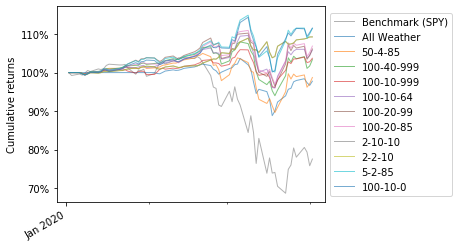

In [29]:
# sort by performance (cumulative returns)
all_ga.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)
test_ga.sort(key=lambda x: x[1]['algorithm_period_return'][-1].item(), reverse=False)

all = [bm_all_weather] + all_ga
test = [bm_aw_test] + test_ga

print('Test on out-of-sample data')
plot_rolling_returns_from_perf_array(test, bm_test)
print_table_from_perf_array(test, bm_test, True)

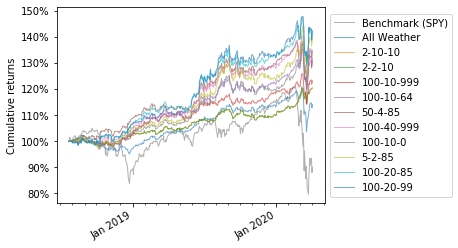

In [30]:
plot_rolling_returns_from_perf_array(all, bm_returns)
print_table_from_perf_array(all, bm_returns, True)

In [31]:
from IPython.display import display, HTML, Javascript
data = [dict(name='foo', value='YES'),
        dict(name='bar', value='NO'),
        dict(name='baz', value='NO'),
        dict(name='foobar', value='YES')]
df = pd.DataFrame(data)

html = df.to_html(classes='my_class')

h = HTML('''
        <style>
            .df tbody tr:last-child { background-color: #FF0000; }
        </style>
        ''' + df.to_html(classes='df'))
a = Javascript('''$('.my_class tbody tr').filter(':last')
                                             .css('background-color', '#FF0000');
                   ''')

display(h)
# display(HTML(html))



We can see that SAW-GA (All-Weather with Sentiments as trading signals, optimised via GA) has resulted in better performance

For All-Weather, we can see that annual, cumulative returns, sharpe ratio are better than the baseline SPY.
But with SAW-GA (Max Returns), we can see that these metrics are even better!

And for risk-adverse individuals, looking to minimise volatility, we can see that SAW-GA (Min Volatility) achieves lower annual volatility, and better max drawdown as compared to All-Weather and the benchmark, while maintaining decent annual returns that still beat the benchmark!

---
---

👷‍♂️ WIP 👷‍♂️

Use Modern Portfolio Theory, but use trading signals to adjust upper and lower bounds of 'risk'.

Let's call this "Sentimental MPT" (SMPT)

Baseline: Modern Portfolio Theory

In [13]:
import sys
sys.path.append('..')  # add parent folder to sys path

import pytz
from datetime import datetime
import pandas as pd
from yahoofinancials import YahooFinancials
import numpy as np

# illustrate theory
tz = pytz.timezone('US/Mountain')
t_end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))  # pd.Timestamp.utcnow()
t_start = t_end - 2500 * pd.tseries.offsets.BDay()

stocks = ['VTI', 'TLT', 'IEF', 'GLD', 'DBC']  # list of stocks used by All-Weather

yahoo_financials = YahooFinancials(stocks)
aw_data = yahoo_financials.get_historical_price_data(
    t_start.strftime('%Y-%m-%d'), 
    t_end.strftime('%Y-%m-%d'), 
    'daily'
)

SIZE = 100
df_data_all = {}
df_data = {} # only last n

for i in range(len(stocks)):
    df_data_all[i] = pd.DataFrame(aw_data[stocks[i]]['prices']).filter(['formatted_date', 'adjclose'])    
    df_data[i] = pd.DataFrame(aw_data[stocks[i]]['prices'])[-(SIZE+1):].filter(['formatted_date', 'adjclose'])
    
prices = pd.DataFrame(np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(stocks)))), columns=stocks)

0.06664432051164414


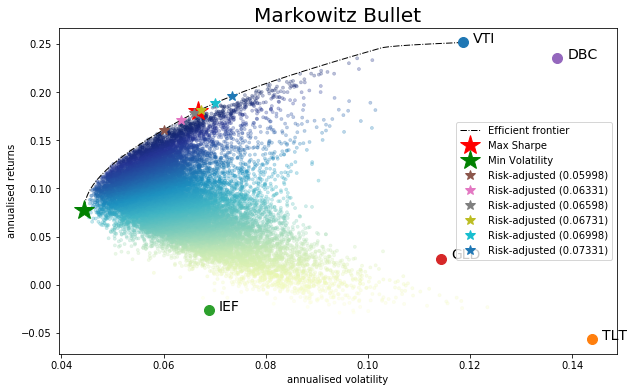

In [14]:
from pypfopt.base_optimizer import portfolio_performance
from utils import generate_markowitz_bullet, get_mu_sigma, optimal_portfolio
import matplotlib.pyplot as plt

# Get mu and S from prices
mu, S = get_mu_sigma(prices)

# w_max_sharpe, _, _ = optimal_portfolio(mu, S, "max_sharpe", get_entire_frontier=False)
w_max_sharpe, opt_ret, opt_risk = optimal_portfolio(mu, S, "max_sharpe", get_entire_frontier=True)
r_ms, v_ms, _ = portfolio_performance(mu, S, w_max_sharpe)
print(v_ms)

# adjust expected volatility - If bullish, we will take more risk/volatility, if bearish, we will take less risk/volatility
vol = [-0.1, -0.05, -0.01, 0.01, 0.05, 0.10]
vol = [v_ms*(1+v) for v in vol]

fig, ax = plt.subplots(figsize=(10, 6))
_ = generate_markowitz_bullet(prices, ax=ax, verbose=False)

for v in vol:
#     print(v)
    weights, _, _ = optimal_portfolio(mu, S, "efficient_risk", get_entire_frontier=False, **{"target_volatility": v})
    r, v, _ = portfolio_performance(mu, S, weights)
    ax.plot(v, r, '*', markersize=10, label=f"Risk-adjusted ({v:.4})")
ax.legend()


In [15]:
from algorithms import OptAlgorithm, run

a_mpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=False, history=args['history'], objective='max_sharpe')
bm_mpt = run("MPT (Max Sharpe)", a_mpt, bundle_name, start, end, capital_base, analyze=False)


# a_smpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
#                       collect_before_trading=False, history=args['history'], objective='max_sharpe')

In [32]:
import ga
import pickle

# Let's train based on data prior to 2020-01-01, and test on data after that.
# This will test whether the optimised parameters are robust and able to perform in the covid-19 market crash

# _end_date = '2020-04-03'
train_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))
train_end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))
test_start = tz.localize(datetime.strptime('2020-01-02', '%Y-%m-%d'))
test_end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))

NPOP = 100
NGEN=10
toSolve = False

pickle_max_ret = "SMPT_GA_MAX_RET"
# pickle_min_vol = "SMPT_GA_MIN_VOL"


kwargs = {"social_media": social_media, "bundle_name": bundle_name, 
          "train_start": train_start, "train_end": train_end, "capital_base": capital_base, "trade_freq": trade_freq}

if toSolve:
    # Solve for max returns
    # top10_max_ret = run_ga("FitnessMax", NPOP, NGEN, "SAW_GA_MAX_RET", eval_fn=eval_cumu_returns)
    top10_max_ret = ga.run_smpt_ga("FitnessMax", NPOP, NGEN, pickle_max_ret,
                       eval_fn=ga.eval_cumu_returns, stocks=stocks, **kwargs)

#     # Solve for min volatility
#     top10_min_vol = ga.run_saw_ga("FitnessMin", NPOP, NGEN, pickle_min_vol, 
#                        eval_fn=ga.eval_min_vol, stocks=stocks, **kwargs)
    
else:
    # load previous results from pickle
    with open(f"{pickle_max_ret}.pickle", "rb+") as f:
        top10_max_ret = pickle.load(f)
    
#     with open(f"{pickle_min_vol}.pickle", "rb+") as f:
#         top10_min_vol = pickle.load(f)

        
best_max_ret = top10_max_ret[0]
# best_min_vol = top10_min_vol[0]
w_max_ret = best_max_ret  # OrderedDict()
# w_min_vol = best_min_vol  # OrderedDict()

# w_max_ret = [-w for w in w_max_ret]

In [33]:
w_max_ret

[-0.09662967591954602, 0.09752211014725048]

GA-optimised SMPT for max sharpe


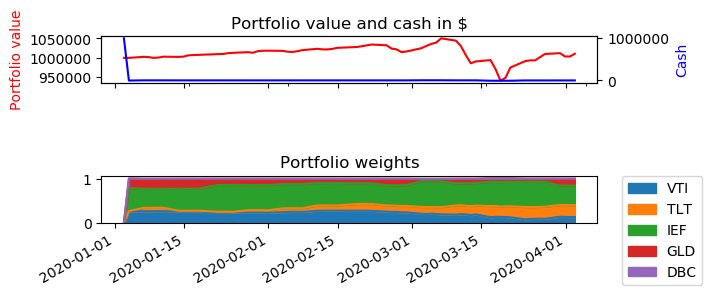

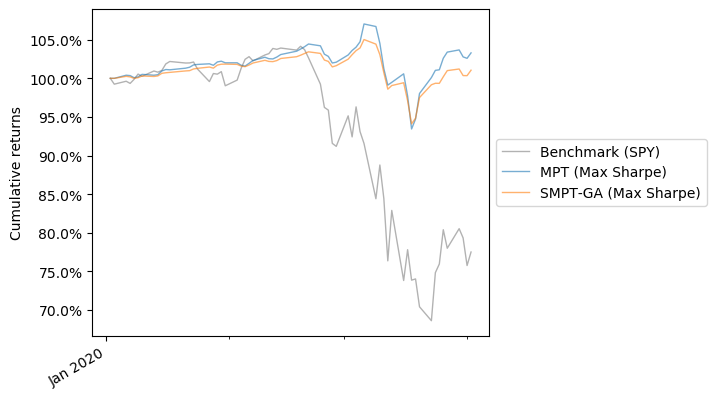

In [34]:
# Test on out-of-sample data
plt.style.use('default')
bm_mpt_test = run("MPT (Max Sharpe)", a_mpt, bundle_name, test_start, test_end, capital_base, analyze=False)

bm_test = get_benchmark_returns(args['benchmark'], test_start, test_end)  # requires network connection
bm_test.name = 'Benchmark (%s)' % args['benchmark']


algo_smpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                         collect_before_trading=False, history=args['history'],
                        rebalance_freq=trade_freq, mpt_adjustment=ga.smpt_ga_trading_fn,
                        **{"weights": w_max_ret, "social_media": social_media})
print("GA-optimised SMPT for max sharpe")
smpt_ga_max_sharpe_test = run("SMPT-GA (Max Sharpe)", algo_smpt, bundle_name, test_start, test_end, capital_base, analyze=True)

plot_rolling_returns_from_perf_array([bm_mpt_test, smpt_ga_max_sharpe_test], bm_test)
print_table_from_perf_array([bm_mpt_test, smpt_ga_max_sharpe_test], bm_test, True)

GA-optimised SMPT for max sharpe


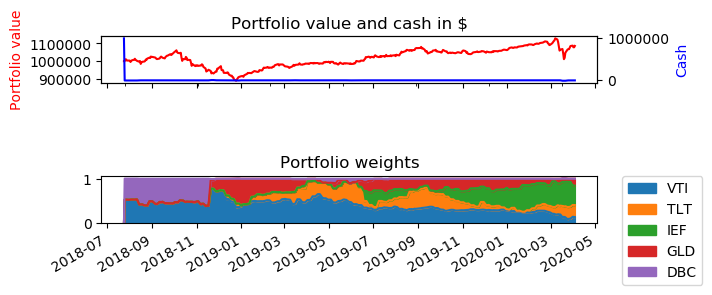

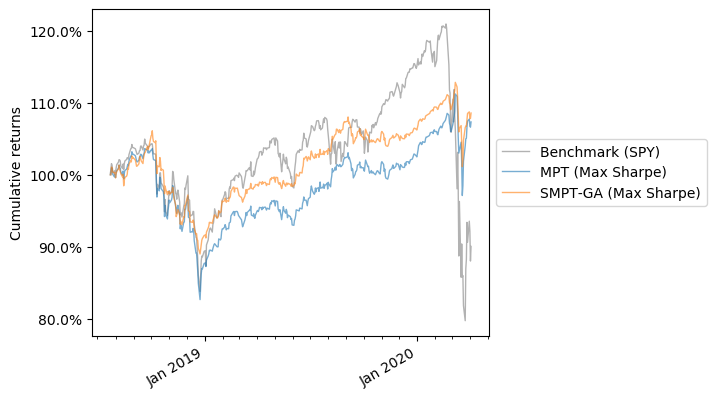

In [35]:
# Test on entire period
a_mpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                      collect_before_trading=False, history=args['history'], objective='max_sharpe')
bm_mpt = run("MPT (Max Sharpe)", a_mpt, bundle_name, train_start, test_end, capital_base, analyze=False)

bm = get_benchmark_returns(args['benchmark'], train_start, test_end)  # requires network connection
bm.name = 'Benchmark (%s)' % args['benchmark']


algo_smpt = OptAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER", 
                         collect_before_trading=False, history=args['history'],
                        rebalance_freq=trade_freq, mpt_adjustment=ga.smpt_ga_trading_fn,
                        **{"weights": w_max_ret, "social_media": social_media})
print("GA-optimised SMPT for max sharpe")
smpt_ga_max_sharpe = run("SMPT-GA (Max Sharpe)", algo_smpt, bundle_name, train_start, test_end, capital_base, analyze=True)


plot_rolling_returns_from_perf_array([bm_mpt, smpt_ga_max_sharpe], bm)
print_table_from_perf_array([bm_mpt, smpt_ga_max_sharpe], bm, True)

Use 1-month strongest and most bullist stocks for portfolio selection (https://www.tradefollowers.com/strength/twitter_strongest.jsp?tf=1m)

In [ ]:
# TODO

In [ ]:
# Get benchmark returns and compare it with our algorithm's returns
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array
from utils import print_table_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']

plot_rolling_returns_from_perf_array(perfTS, bm_returns)
print_table_from_perf_array(perfTS, bm_returns, True)

# Testing area

### Toy-example for Modern Portfolio Theory (MPT) 
Modern portfolio theory applied on randomly-generated returns for a number of assets

Adapted from https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Expected annual return: 280.8%
Annual volatility: 1558.5%
Sharpe Ratio: 0.18
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Expected annual return: -411.3%
Annual volatility: 779.2%
Sharpe Ratio: -0.53


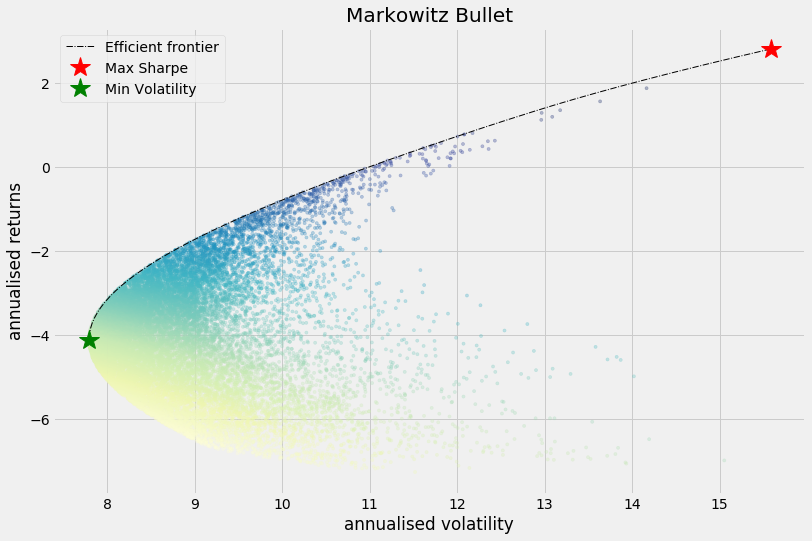

In [6]:
import sys
sys.path.append('..')  # add parent folder to sys path

import numpy as np
import pandas as pd
from utils import optimal_portfolio, generate_markowitz_bullet
from pypfopt import expected_returns

n_assets = 4 # number of different stocks
n_obs = 1000 # number of history points to take mean of
return_vec = np.random.randn(n_obs, n_assets) # randomly create returns

prices_ = expected_returns.prices_from_returns(pd.DataFrame(return_vec))
_ = generate_markowitz_bullet(prices_, num_random=20000, plot_individual=False)

### Modern Portfolio Theory (MPT) applied on actual stocks
Using assets selected in Vanguard ETF strategic model portfolios (Core Series), according to
https://advisors.vanguard.com/iwe/pdf/FASINVMP.pdf

In [7]:
import pandas as pd
from yahoofinancials import YahooFinancials  # https://github.com/JECSand/yahoofinancials

end = tz.localize(datetime.strptime('2020-01-01', '%Y-%m-%d'))  # pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

# Vanguard Core Series
tickers = ['VTI', 'VXUS', 'BND', 'BNDX']

yahoo_financials = YahooFinancials(tickers)
data = yahoo_financials.get_historical_price_data(
    start.strftime('%Y-%m-%d'), 
    end.strftime('%Y-%m-%d'), 
    'daily'
)

In [8]:
import plotly.graph_objects as go
import numpy as np

SIZE = 100
data_title = 'VANGUARD Core Series'

df_data_all = {}
df_data = {} # only last n

for i in range(len(tickers)):
    df_data_all[i] = pd.DataFrame(data[tickers[i]]['prices']).filter(['formatted_date', 'adjclose'])    
    df_data[i] = pd.DataFrame(data[tickers[i]]['prices'])[-(SIZE+1):].filter(['formatted_date', 'adjclose'])
    
# returns_V = np.column_stack((df1, df2, df3, df4))
returns_V = np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(tickers))))
returns_V = np.diff(returns_V, axis=0) / returns_V[1:,:] * 100
print('Shape of returns:', returns_V.shape)
print(returns_V[0:5])

# Plot historical data
fig = go.Figure()
for i in range(len(tickers)):
    fig.add_trace(go.Scatter(x=df_data_all[i]['formatted_date'], 
                             y=df_data_all[i]['adjclose'], 
                             name=tickers[i], 
#                              line_color='deepskyblue', 
                             opacity=0.8))
    
# Use date string to set xaxis range
fig.update_layout(xaxis_range=[start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')],
                   title_text="Components in %s" % data_title)
fig.show()

Shape of returns: (100, 4)
[[-0.71851633 -0.77412133 -0.17861049  0.08553383]
 [-1.25102239 -0.982159    0.43867238  0.10253401]
 [ 1.4077001   1.09040049 -0.15435583  0.25565625]
 [-2.97507897 -2.89677479  0.35497522  0.22109802]
 [ 0.18602273  0.3658625   0.482807    0.62530625]]


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Expected annual return: 14.5%
Annual volatility: 4.7%
Sharpe Ratio: 2.69
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Expected annual return: 5.3%
Annual volatility: 3.0%
Sharpe Ratio: 1.11


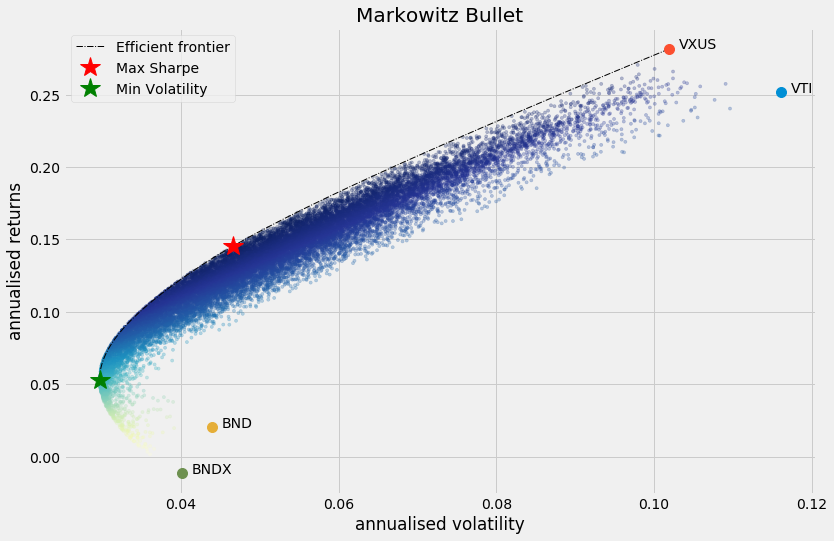

In [9]:
# Markowitz bullet representation inspired from 
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

import pandas as pd
import numpy as np
from utils import generate_markowitz_bullet, get_mu_sigma

prices = pd.DataFrame(np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(tickers)))), columns=tickers)
_ = generate_markowitz_bullet(prices)

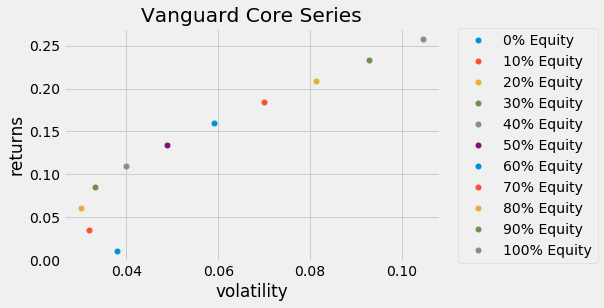

In [24]:
from pypfopt.base_optimizer import portfolio_performance
import matplotlib.pyplot as plt
from utils import get_mu_sigma


# VTI, VXUS, BND, BNDX
core_series_allocation = {
    0: (0, 0, 0.686, 0.294),
    1: (0.059, 0.039, 0.617, 0.265),
    2: (0.118, 0.078, 0.549, 0.235),
    3: (0.176, 0.118, 0.480, 0.206),
    4: (0.235, 0.157, 0.412, 0.176),
    5: (0.294, 0.196, 0.343, 0.147),
    6: (0.353, 0.235, 0.274, 0.118),
    7: (0.412, 0.274, 0.206, 0.088),
    8: (0.470, 0.314, 0.137, 0.059),
    9: (0.529, 0.353, 0.069, 0.029),
    10: (0.588, 0.392, 0, 0)
}

# Get mu and S from prices
mu, S = get_mu_sigma(prices)

# Plot different risk-level portfolios from Vanguard Core Series on same graph
for k,allocation in core_series_allocation.items():
    returns, volatility, _ = portfolio_performance(mu, S, allocation)
    plt.plot(volatility, returns, 'o', markersize=5, label='%i%% Equity' % (k*10))
    
plt.xlabel('volatility')
plt.ylabel('returns')
plt.title('Vanguard Core Series')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
print()


In [ ]:
import os
import sys
sys.path.append('../models/lstm_nn')  # add parent folder to sys path
# os.chdir('../models/lstm_nn')

import json
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model

toTrain = False

# get LSTM configuration details from config.json
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# train model
if toTrain:
    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
    # in-memory training
    model.train(
        x,
        y,
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size'],
        save_dir = configs['model']['save_dir']
    )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )


else:
    # Get predictions
    import glob
    list_of_files = glob.glob(configs['model']['save_dir'] + '/*h5') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)

    model_use = Model()
    model_use.load_model(latest_file)    
    
    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )
    
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.legend()
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.show()

In [ ]:
predictions = model_use.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])